# **Relationships & Predictions in Spam Texts**

# Data & Problem

The goal of my project is to discover relationships between words in spam texts and predict whether or not a text is spam. The data is a corpus of texts compiled from a spam complaint website in the UK and a set of legitimate texts from the National University of Singapore.

Citation: Almeida,Tiago and Hidalgo,Jos. (2012). SMS Spam Collection. UCI Machine Learning Repository. https://doi.org/10.24432/C5CC84.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv('data/SMSSpamCollection.txt', sep='\t', header=None, names=['spam_or_ham', 'text'])

# Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

## About the data

In [25]:
print(data.head())

  spam_or_ham                                               text
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...


In [26]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   spam_or_ham  5572 non-null   object
 1   text         5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


We have **5572** entries with **text** values and a classification of **spam** or **ham**. There is an imbalance in the data that we will have to keep in mind throughout the project.

In [27]:
print(data.describe())

       spam_or_ham                    text
count         5572                    5572
unique           2                    5169
top            ham  Sorry, I'll call later
freq          4825                      30


Next, let's look at what sorts of unique values we have in the data.

In [28]:
for col in data.columns:
    print(f'{col}:')
    print(data[col].unique())

spam_or_ham:
['ham' 'spam']
text:
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
 'Ok lar... Joking wif u oni...'
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
 ... 'Pity, * was in mood for that. So...any other suggestions?'
 "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free"
 'Rofl. Its true to its name']


## Factors

| Component | Details |
| --- | --- |
| spam_or_ham | "spam" or "ham" indicating if the text is spam or not. I'll convert this into a boolean later. |
| text | This is the content of the message. Within this are the words that we'll discover relationships between and use to make predictions. |

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['text'])
word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq_total = word_freq_df.sum().sort_values(ascending=False)
print(word_freq_total.head(20))
print('...')
print(word_freq_total.tail(20))

to      2253
you     2245
the     1339
and      980
in       903
is       897
me       807
my       766
it       752
for      711
your     681
of       623
call     593
that     586
have     578
on       538
now      499
are      495
can      471
so       462
dtype: int64
...
heehee                 1
helps                  1
helping                1
helpful                1
help08714742804        1
help08700621170150p    1
hellogorgeous          1
helens                 1
hehe                   1
hectic                 1
healer                 1
heavily                1
heaven                 1
heat                   1
hearted                1
hearing                1
hearin                 1
heap                   1
healthy                1
〨ud                    1
dtype: int64


## Cleaning

First, I want to check for and remove missing values to ensure we are working with a complete set.

In [30]:
print(data.isnull().sum())
data = data.dropna()
print(data.isnull().sum())


spam_or_ham    0
text           0
dtype: int64
spam_or_ham    0
text           0
dtype: int64


Let's convert the SpamOrHam column to a column called Spam that just indicates True or False for better interpretability in the models.

In [31]:
data['spam'] = data['spam_or_ham'] == 'spam'
data = data.drop(columns=['spam_or_ham'])

In [32]:
print(data.head())

                                                text   spam
0  Go until jurong point, crazy.. Available only ...  False
1                      Ok lar... Joking wif u oni...  False
2  Free entry in 2 a wkly comp to win FA Cup fina...   True
3  U dun say so early hor... U c already then say...  False
4  Nah I don't think he goes to usf, he lives aro...  False


## Correlation

There is correlation present between the words in the texts, which can be seen when the unsupervised learning methods discover and present relationships between words -- this is in part due to correlation between the frequently used words.

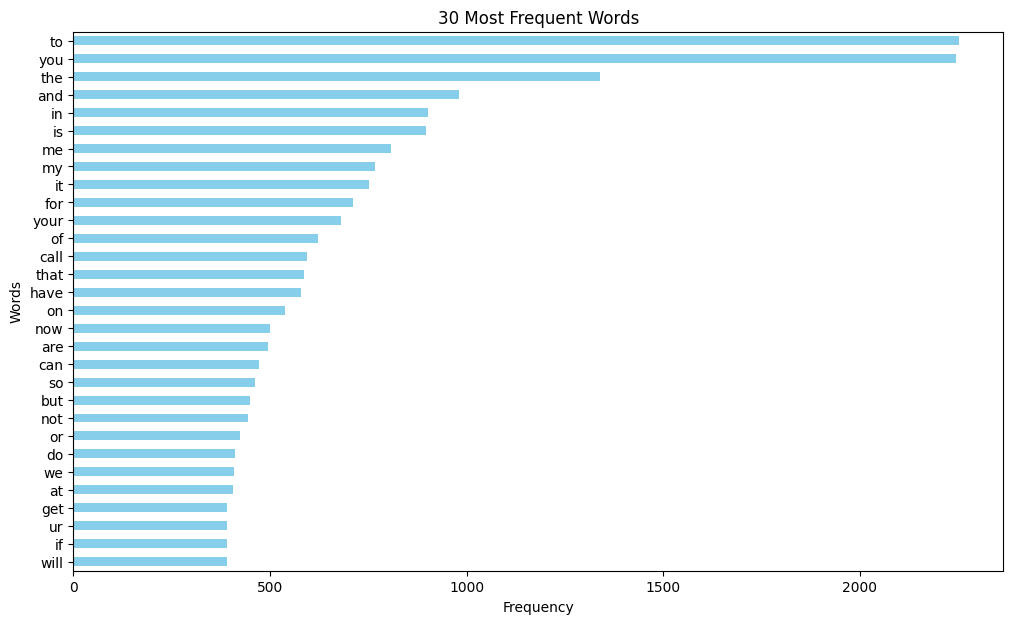

In [33]:
word_freq_total.head(30).plot(kind='barh', figsize=(12, 7), color='skyblue')
plt.title('30 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.show()

## Transformation

The data will need to be transformed in a few different ways for the various methods I will try. One common transformation I will need is preprocessing: removing stop words (because they lack meaning needed to define relationships), making the text lowercase, and removing punctuation and digits (leaving only text).

In [34]:
# text preprocessing

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

data['text'] = data['text'].apply(preprocess_text)

I will vectorize text to help reduce dimensionality as well as make it more consumable by the machine learning methods I'll implement.

In [35]:
# creating a vectorized version of data['text'] for repeated use
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
text_vectors = vectorizer.fit_transform(data['text'])

Summary: In this previous section, I ensured that my data was ready for use in my models. I already started discovering interesting aspects of my data like the most frequently used words.

# Models

## Unsupervised Learning: 

### NMF

Here I can find some of the topics and top words in those topics. A few topics in this list like index 3 and 8 seem highly likely to contain spam. 

In [63]:
from sklearn.decomposition import NMF


nmf_model = NMF(n_components=10, random_state=40)
W = nmf_model.fit_transform(text_vectors)
H = nmf_model.components_


feature_names = vectorizer.get_feature_names_out()

def top_topic_words(H, feature_names, top_count):
    for i, topic in enumerate(H):
        print(f"{i}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-top_count - 1:-1]]))

top_topic_words(H, feature_names, 8)

0:
ok thanx prob ur leave yup said ya
1:
ll later sorry meeting aight text yeah tonight
2:
gt lt min like decimal minutes rs got
3:
free ur text txt reply mobile nokia week
4:
come time tomorrow want oh got tell tonight
5:
good day know love just dear hope night
6:
lor wat wan dun time doing got thk
7:
home going way coming ur da reach dinner
8:
prize claim won guaranteed urgent contact valid cash
9:
send pls message pick right phone da number


In [64]:
print(f"Reconstruction Error: {nmf_model.reconstruction_err_}")

Reconstruction Error: 72.14328496054976


In [37]:
data_with_topic = data.copy()
data_with_topic['topic'] = W.argmax(axis=1)
print(data_with_topic)

                                                   text   spam  topic
0     jurong point crazy available bugis n great wor...  False      6
1                               ok lar joking wif u oni  False      0
2     free entry wkly comp win fa cup final tkts st ...   True      3
3                           u dun say early hor u c say  False      6
4                        nah don t think goes usf lives  False      5
...                                                 ...    ...    ...
5567  nd time tried contact u u won pound prize clai...   True      8
5568                        ü b going esplanade fr home  False      7
5569                              pity mood suggestions  False      5
5570  guy did bitching acted like d interested buyin...  False      3
5571                                          rofl true  False      3

[5572 rows x 3 columns]


/opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


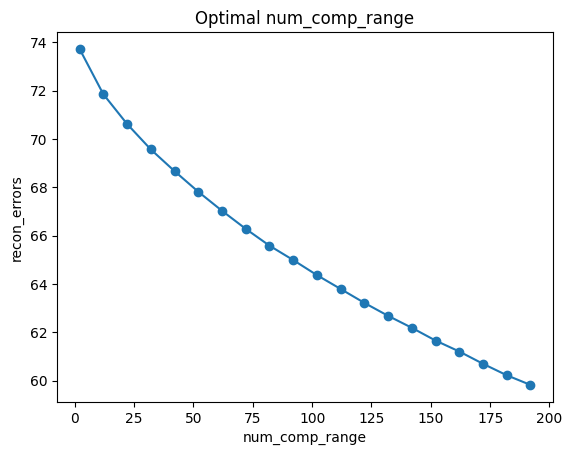

In [68]:
recon_errors = []
num_comp_range = range(2, 200, 10)

for n in num_comp_range:
    nmf_model = NMF(n_components=n, random_state=40)
    W = nmf_model.fit_transform(text_vectors)
    H = nmf_model.components_
    recon_errors.append(nmf_model.reconstruction_err_)

plt.plot(num_comp_range, recon_errors, marker='o')
plt.title('Optimal num_comp_range')
plt.xlabel('num_comp_range')
plt.ylabel('recon_errors')
plt.show()

### Word Embedding and KMeans

Next, I'll explore KMeans and implement word embeddings.

In [38]:
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

# transforming text into tokens for word embeddings
nltk.download('stopwords')
stop_words = stopwords.words('english')

def tokenize(text):
    tokens = simple_preprocess(text, deacc=True)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# making a copy for use in kmeans so I do not contaminate the original data
kmeans_data = data.copy()
kmeans_data['text'] = kmeans_data['text'].apply(tokenize)

wordvector = Word2Vec(sentences=kmeans_data['text'], vector_size=100, window=5, min_count=1, workers=4, sg=0)



[nltk_data] Downloading package stopwords to /Users/grant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
print(wordvector.wv['hi'])

[-0.06895319  0.15644959  0.02670699  0.00827242  0.02344137 -0.27977613
  0.07541046  0.36618865 -0.1282766  -0.08574257 -0.09389766 -0.2964607
 -0.01384152  0.07414988  0.02600762 -0.14203876  0.04939359 -0.2478874
  0.02908015 -0.35246703  0.14440703  0.07232866  0.07294117 -0.06004795
 -0.0495735  -0.02335776 -0.12769324 -0.10890828 -0.19904968 -0.01216016
  0.2226332   0.07609785  0.06492973 -0.12146782 -0.08951806  0.20205829
 -0.00091277 -0.09843437 -0.09471009 -0.32645512  0.01965761 -0.16158678
 -0.06573282  0.00872378  0.10490158 -0.08986989 -0.16302007  0.0121245
  0.09710385  0.09472079  0.0322605  -0.14596443 -0.05155375 -0.02398416
 -0.11356739  0.14680389  0.0928212  -0.06193853 -0.17254694  0.07646728
  0.02110785  0.06185143 -0.04827413  0.04516925 -0.16200599  0.1495606
 -0.02340137  0.11424728 -0.22147515  0.20445438 -0.10974868  0.09784049
  0.22033553 -0.07812329  0.18885884  0.10619929 -0.01418979 -0.0439624
 -0.1743503   0.04885028 -0.03663962 -0.04173398 -0.2028

In [40]:
wordvector.wv.most_similar('home', topn=3)

[('good', 0.9991819858551025),
 ('time', 0.9991481304168701),
 ('like', 0.9991405606269836)]

In [41]:
wordvector.wv.most_similar('prize', topn=3)

[('claim', 0.9983595013618469),
 ('txt', 0.9982503056526184),
 ('contact', 0.9978494644165039)]

In [42]:
wordvector.wv.most_similar('urgent', topn=3)


[('txt', 0.9975656270980835),
 ('ur', 0.9975178241729736),
 ('free', 0.9974448680877686)]

In [43]:
wordvector.wv.most_similar('meeting', topn=3)


[('told', 0.9899023771286011),
 ('wat', 0.9898195862770081),
 ('message', 0.9895045161247253)]

In [44]:
def doc_vec(doc):
    doc = [word for word in doc if word in wordvector.wv.index_to_key]
    return np.mean(wordvector.wv[doc], axis=0) if doc else np.zeros(wordvector.vector_size)

kmeans_data['doc_vector'] = kmeans_data['text'].apply(doc_vec)
X = np.vstack(kmeans_data['doc_vector'].values)

km = KMeans(n_clusters= 2, random_state=40)
km.fit(X)

kmeans_data['cluster'] = km.labels_

Here, I can see the true classification of points in the two clusters.

In [45]:
print(pd.crosstab(kmeans_data['spam'], kmeans_data['cluster']))

cluster     0     1
spam               
False    2813  2012
True      333   414


In [46]:
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, km.labels_)}")

Silhouette Score: 0.5358477311644246


We can see that the Silhouette needs improvement as it ranges [-1,1] with 1 being good clustering.

In [47]:
from sklearn.metrics import adjusted_rand_score

print(f"Adjusted Rand Index: {adjusted_rand_score(kmeans_data['spam'], km.labels_)}")

Adjusted Rand Index: 0.016176573183229365


We can see that the ARI needs improvement as it ranges [-1,1] with 1 being good clustering.

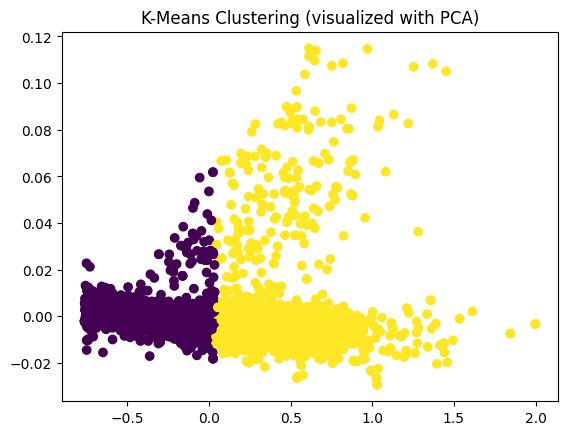

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='viridis')
plt.title("K-Means Clustering (visualized with PCA)")
plt.show()

**KMeans Hyperparameter tuning**

In [50]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_clusters': [2, 8, 16, 20],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [100, 300, 400]
}

km_gs = KMeans(random_state=40)

randomized_search = RandomizedSearchCV(km_gs, param_distributions=param_dist, n_iter=10, scoring='adjusted_rand_score', random_state=40)
randomized_search.fit(X, kmeans_data['spam'])

RandomizedSearchCV(estimator=KMeans(random_state=40),
                   param_distributions={'init': ['k-means++', 'random'],
                                        'max_iter': [100, 300, 400],
                                        'n_clusters': [2, 8, 16, 20],
                                        'n_init': [10, 20]},
                   random_state=40, scoring='adjusted_rand_score')

In [51]:
print(f"Best Parameters: {randomized_search.best_params_}")
print(f"Best ARI: {randomized_search.best_score_}")

Best Parameters: {'n_init': 10, 'n_clusters': 2, 'max_iter': 400, 'init': 'k-means++'}
Best ARI: 0.016385769734162045


### Latent Dirichlet Allocation (LDA)

In [52]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

lda_data = data.copy()
lda_data['text'] = lda_data['text'].apply(tokenize)

dictionary = Dictionary(lda_data['text'])

dictionary.filter_extremes(no_below=5, no_above=0.5)

# bag of words
corpus = [dictionary.doc2bow(text) for text in lda_data['text']]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=40, passes=10)

topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.051*"gt" + 0.050*"lt" + 0.024*"stop" + 0.018*"text" + 0.016*"send" + 0.012*"reply" + 0.012*"number" + 0.011*"free" + 0.011*"min" + 0.009*"chat"')
(1, '0.029*"want" + 0.028*"know" + 0.024*"free" + 0.023*"come" + 0.021*"pls" + 0.014*"right" + 0.013*"phone" + 0.013*"dont" + 0.012*"yes" + 0.012*"need"')
(2, '0.021*"later" + 0.020*"got" + 0.017*"sorry" + 0.013*"ask" + 0.013*"say" + 0.012*"think" + 0.012*"hi" + 0.011*"know" + 0.010*"hey" + 0.010*"oh"')
(3, '0.040*"ur" + 0.021*"txt" + 0.018*"claim" + 0.015*"prize" + 0.014*"cash" + 0.012*"win" + 0.011*"free" + 0.010*"mobile" + 0.010*"urgent" + 0.010*"www"')
(4, '0.031*"ok" + 0.024*"good" + 0.021*"day" + 0.019*"home" + 0.017*"love" + 0.015*"going" + 0.014*"lor" + 0.013*"hope" + 0.013*"time" + 0.013*"like"')


Here we can see the relationships LDA found between "send", "text", "reply", and "stop" which likely follow the FCC texting opt in guidelines. There's also an interesting grouping of "love", "home", and "hope".

It seems likely here that this topic has more of the spam words:

(3, '0.040*"ur" + 0.021*"txt" + 0.018*"claim" + 0.015*"prize" + 0.014*"cash" + 0.012*"win" + 0.011*"free" + 0.010*"mobile" + 0.010*"urgent" + 0.010*"www"')


In [53]:
def get_document_topics(corpus, model):
    doc_topics = [model.get_document_topics(item) for item in corpus]
    return doc_topics

lda_data['topics'] = get_document_topics(corpus, lda)

Topic 0:


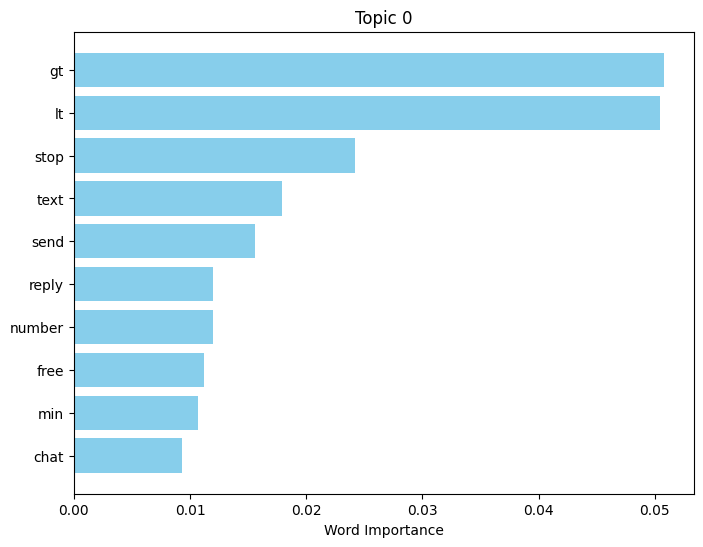

Topic 1:


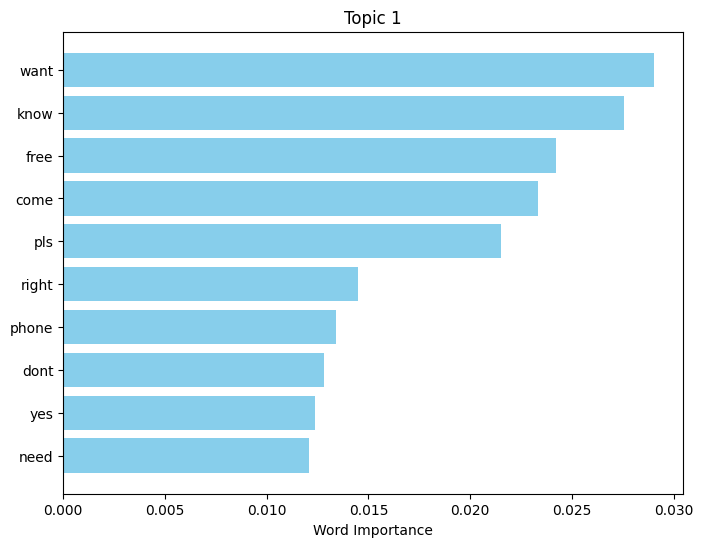

Topic 2:


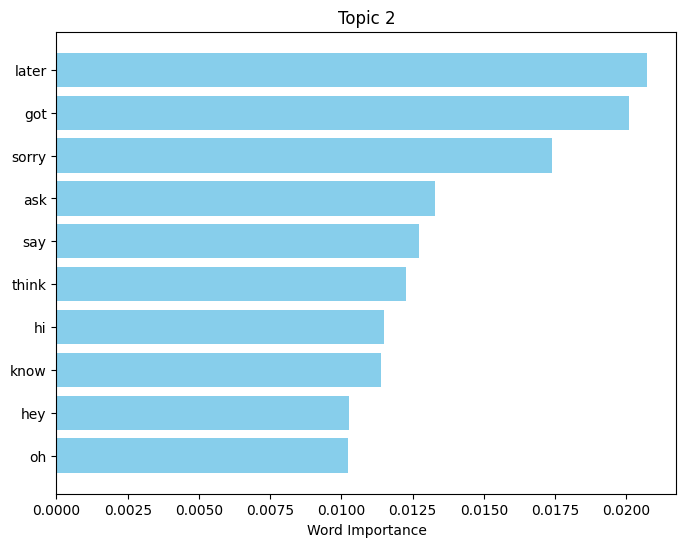

Topic 3:


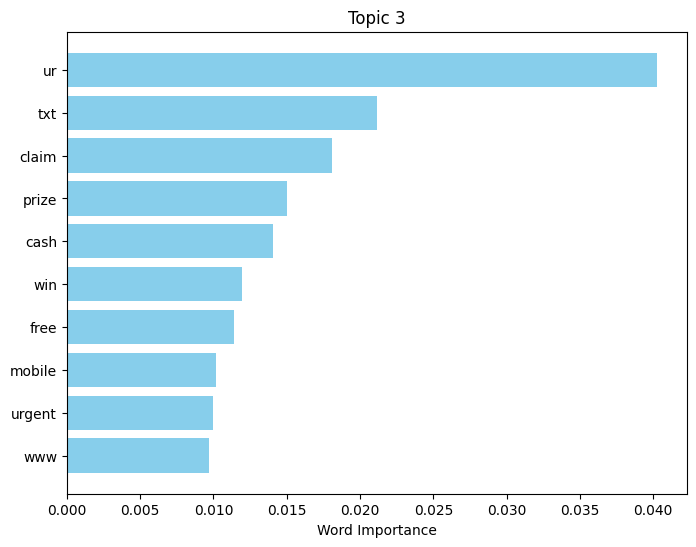

Topic 4:


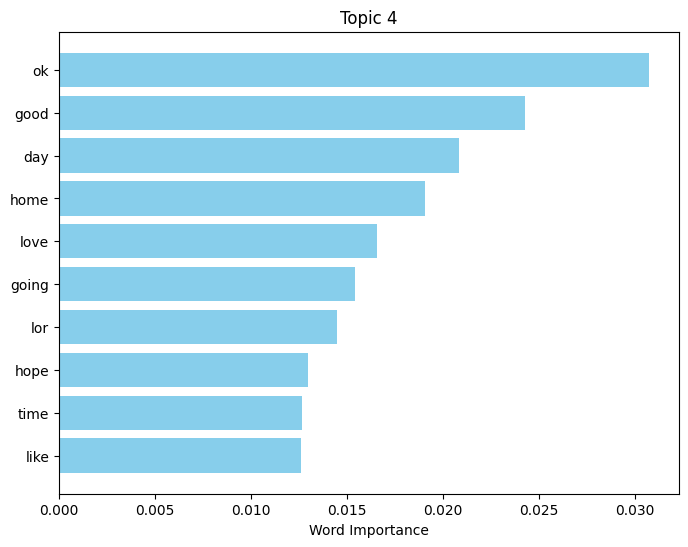

In [54]:
def plot_top_words(lda_model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(lda_model.get_topics()):
        print(f"Topic {topic_idx}:")
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        plt.figure(figsize=(8, 6))
        plt.barh(top_features, weights, color='skyblue')
        plt.gca().invert_yaxis()
        plt.title(f"Topic {topic_idx}")
        plt.xlabel("Word Importance")
        plt.show()

plot_top_words(lda, dictionary.id2token, n_top_words=10)

In [55]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=lda_data['text'], dictionary=dictionary, coherence='c_v')
print(f'Coherence Score: {coherence_model_lda.get_coherence()}')

Coherence Score: 0.32087433407050286


**Hyperparameter tuning**

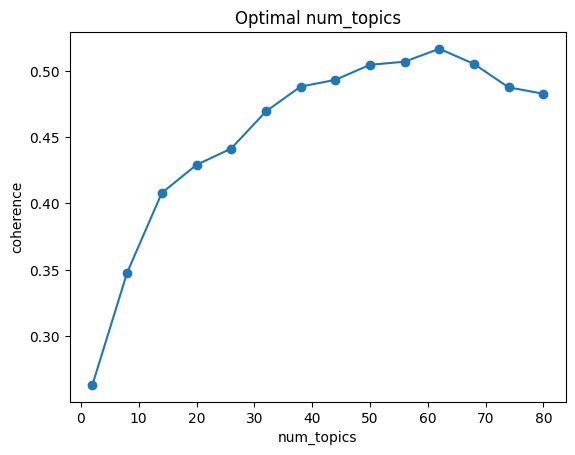

In [56]:
coherences = []
num_topics_range = range(2, 81, 6)

for n in num_topics_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n, random_state=40, passes=10)
    coherence_model_lda = CoherenceModel(model=lda, texts=lda_data['text'], dictionary=dictionary, coherence='c_v')
    coherences.append(coherence_model_lda.get_coherence())

plt.plot(num_topics_range, coherences, marker='o')
plt.title('Optimal num_topics')
plt.xlabel('num_topics')
plt.ylabel('coherence')
plt.show()

In [57]:
# use best num_topics

lda_data = data.copy()
lda_data['text'] = lda_data['text'].apply(tokenize)

dictionary = Dictionary(lda_data['text'])

dictionary.filter_extremes(no_below=5, no_above=0.5)

# bag of words
corpus = [dictionary.doc2bow(text) for text in lda_data['text']]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=66, random_state=40, passes=10)
coherence_model_lda = CoherenceModel(model=lda, texts=lda_data['text'], dictionary=dictionary, coherence='c_v')
print(f'Coherence Score: {coherence_model_lda.get_coherence()}')
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)

Coherence Score: 0.5140322267456953
(55, '0.077*"speak" + 0.076*"wot" + 0.074*"live" + 0.063*"town" + 0.045*"saturday"')
(40, '0.138*"right" + 0.114*"thanks" + 0.060*"receive" + 0.059*"princess" + 0.057*"award"')
(13, '0.144*"reply" + 0.072*"th" + 0.055*"tones" + 0.036*"apply" + 0.035*"offer"')
(9, '0.128*"said" + 0.109*"sleep" + 0.102*"fine" + 0.065*"god" + 0.040*"true"')
(22, '0.196*"yeah" + 0.085*"shit" + 0.082*"guys" + 0.080*"weekend" + 0.068*"like"')
(24, '0.304*"think" + 0.153*"gonna" + 0.091*"people" + 0.074*"fuck" + 0.065*"times"')
(42, '0.256*"going" + 0.102*"wat" + 0.096*"say" + 0.052*"ready" + 0.051*"watch"')
(12, '0.342*"good" + 0.064*"lot" + 0.060*"boy" + 0.049*"morning" + 0.030*"parents"')
(4, '0.174*"got" + 0.140*"yes" + 0.091*"dun" + 0.075*"thk" + 0.054*"ah"')
(30, '0.101*"cash" + 0.067*"service" + 0.060*"dis" + 0.053*"send" + 0.043*"dude"')
(53, '0.207*"dear" + 0.133*"care" + 0.062*"gud" + 0.045*"day" + 0.037*"ni"')
(29, '0.108*"try" + 0.103*"lunch" + 0.070*"pa" + 0.07

Here are some interesting outcome of this LDA. You can see how it found the relationships between "im", "tel", and "chat". There is also a relationship noted between "apply" and "offer". 

Its likely that topic three in this case contains key spam words: 
(13, '0.144*"reply" + 0.072*"th" + 0.055*"tones" + 0.036*"apply" + 0.035*"offer"')

### Isolation Forest

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test = train_test_split(data, test_size=0.2, random_state=40)
vectorizer = TfidfVectorizer()

X_train_vector = vectorizer.fit_transform(X_train['text'])
X_test_vector = vectorizer.transform(X_test['text'])

iso_forest = IsolationForest(contamination=0.1, random_state=40)

# fit and predict iso_forest
iso_forest.fit(X_train_vector)
y_pred = iso_forest.predict(X_test_vector)

# pull out the spam boolean as -1 or 1
y_test = X_test['spam'].apply(lambda x: -1 if x else 1)
print(y_pred)
print(y_test.values)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

          -1       0.32      0.19      0.24       144
           1       0.89      0.94      0.91       971

    accuracy                           0.84      1115
   macro avg       0.60      0.57      0.58      1115
weighted avg       0.81      0.84      0.83      1115

[[ 28 116]
 [ 59 912]]


**Hyperparameter tuning with Isolation Forest**

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_samples': ['auto', 0.5, 0.75],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [1.0, 0.8, 0.5],
    'bootstrap': [False, True],
    'random_state': [40]
}

y_train = X_train['spam'].apply(lambda x: -1 if x else 1)


iso_gs = IsolationForest()
grid_search = GridSearchCV(estimator=iso_gs, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_vector, y_train)
print(grid_search.best_params_)


{'bootstrap': False, 'contamination': 0.1, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 400, 'random_state': 40}


In [74]:
# using the best params
iso_forest = IsolationForest(contamination=0.1, random_state=40, max_features=1, max_samples=0.5, n_estimators=400, bootstrap=False)
iso_forest.fit(X_train_vector)

y_pred = iso_forest.predict(X_test_vector)

# pull out the spam boolean as -1 or 1
y_test = X_test['spam'].apply(lambda x: -1 if x else 1)

print(y_pred)
print(y_test.values)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

          -1       0.38      0.19      0.25       144
           1       0.89      0.95      0.92       971

    accuracy                           0.85      1115
   macro avg       0.63      0.57      0.58      1115
weighted avg       0.82      0.85      0.83      1115

[[ 27 117]
 [ 45 926]]


## Supervised Learning: 

### Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X = text_vectors
y = data['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

lgr = LogisticRegression()

# fit LogisticRegression and make prediction
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)

print("accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy:  0.9605381165919282
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       971
        True       0.97      0.72      0.82       144

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115



### MultinomialNB

In [78]:
from sklearn.naive_bayes import MultinomialNB

X = text_vectors
y = data['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

mnb = MultinomialNB()

# fit MultinomialNB and make prediction
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

# print accuracy and classification_report
print("accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy:  0.9704035874439462
              precision    recall  f1-score   support

       False       0.97      1.00      0.98       971
        True       1.00      0.77      0.87       144

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [80]:
# tune hyperparameter alpha
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
for a in alphas:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    print("accuracy: ", accuracy_score(y_test, y_pred))

accuracy:  0.9748878923766816
accuracy:  0.9775784753363229
accuracy:  0.9704035874439462
accuracy:  0.9479820627802691
accuracy:  0.9031390134529148
accuracy:  0.8753363228699551


In [83]:
# run the best alpha
mnb = MultinomialNB(alpha=0.5)
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print("accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


accuracy:  0.9775784753363229
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       971
        True       0.98      0.84      0.91       144

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



# Results & Analysis

### Summary

I implemented unsupervised methods (NMF, KMeans, and LDA) and supervised methods (Logistic Regression and MultinomialNB). For the unsupervised methods, I had the goal of learning about the words that make up spam and the relationships between the words in the corpus in general. I also experimented with word embeddings and used TF-IDF for vectorizing the texts.

Through NMF and LDA, I was able to find topic groups of words with relationships between them. Notably, through LDA I found a topic grouping that appeared to group many likely spam words, as shown in this graph.

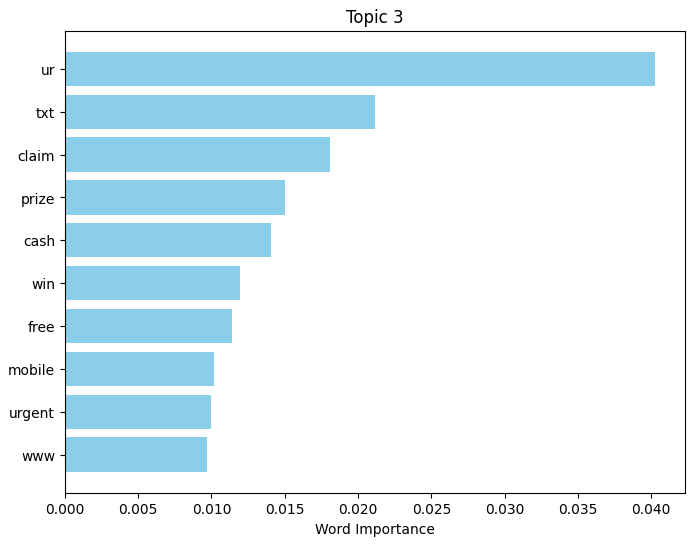

### Performance

For KMeans, I was able to achieve a silhouette score of 0.5349 which fell short of what I would like to have achieved, as it ranges from -1 to 1. I achieved an ARI of 0.0155 after tuning parameters and iterating, which is also lacking because that ranges from -1 to 1.

For LDA, I had a coherence score (measuring the quality of topics) of 0.514. I used this metric to ensure my groupings made sense. I also visually inspected words in the groupings and understood the relationships between them. For NMF, I found a good balance between reconstruction error and complexity of groupings (having too many groupings).

I used Isolation Forest, Logistic Regression, and MultinomialNB to create models for predicting whether or not a text was spam. After hyperparameter tuning I achieved the following results in my selected metrics. I focused on accuracy as well as precision, recall, and f1-score in the minority class due to the imbalance in data. MultinomialNB performed the best.


**Isolation Forest:** <br/>
Accuracy: 0.84 <br/>
This struggled on the minority class.
<div style="display: inline-block;">
    
|| precision | recall | f1-score | support |
|---|---|---|---|---|
|False|0.89|0.95|0.92|971|
|True|0.38|0.19|0.25|144|

</div>

**Logistic Regression:** <br/>
Accuracy: 0.9605
<div style="display: inline-block;">
    
|| precision | recall | f1-score | support |
|---|---|---|---|---|
|False|0.96|1.00|0.98|971|
|True|0.97|0.72|0.82|144|

</div>

**MultinomialNB:** <br/>
Accuracy: 0.9776
This method performed the best.
<div style="display: inline-block;">
    
|| precision | recall | f1-score | support |
|---|---|---|---|---|
|False|0.98|1.00|0.99|971|
|True|0.98|0.84|0.91|144|

</div>



# Discussion

Throughout this project, for each model, I iterated on them to improve performance where possible. This was simpler to do with the supervised learning methods Logistic Regression and MultinomialNB because the goal with them was more straightforward -- accurately make predictions when given test texts. For the unsupervised methods I tried, I was able to iterate on NMF and LDA to find interesting relationships in the text. 

I had a goal with Isolation Forest to predict one test data, but I couldn't make it work well for predicting. I also struggled to have KMeans make meaningful clusters -- however, I was able to use and understand word vectors better through this process.

Supervised learning was much better suited for making predictions about whether text was spam or not. Unsupervised learning allowed me to understand the texts and the relationships between the words within them.

I think I could improve this project by using unsupervised methods to find relationships in the texts and then use those relationships in the supervised learning methods.